# Tutorial for nyaggle
This Jupyter Notebook basic usage.

1. Intall nyaggle
1. Feature engineering
1. Call `run_experiment` with mlflow
1. See result with mlflow

## Install nyaggle
You can install nyaggle via [pip](https://pypi.org/project/nyaggle/)

In [1]:
# This Tutorial need to mlflow
!pip install --quiet mlflow

In [ ]:
# This Tutorial need to lightgbm
!pip install --quiet lightgbm

In [2]:
!pip install --quiet nyaggle

In [1]:
import nyaggle

nyaggle.__version__

'0.1.2'

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# [](https://www.kaggle.com/c/titanic/data)
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv")

In [3]:
target_col = 'Survived'
target = train[target_col]
train.drop(columns=[target_col], inplace=True)

In [4]:
is_train = 'is_train'
train[is_train] = 1
test[is_train] = 0

In [5]:
data = pd.concat([train, test], sort=False).reset_index(drop=True)

In [6]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


## Feature engineering

In [7]:
import nyaggle.feature_store as fs

# @fs.cached_feature("all_feature")
def all_feature(df: pd.DataFrame) -> pd.DataFrame:
    df['Sex'] = df['Sex'].replace(['male','female'], [0, 1])
    df['Embarked'] = df['Embarked'].fillna(('S'))
    df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    df['Fare'] = df['Fare'].fillna(np.mean(df['Fare']))
    df['Age'] = df['Age'].fillna(df['Age'].median())
    delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
    df = df.drop(delete_columns, axis=1)
    return df

In [8]:
_all_feature = all_feature(data)

In [9]:
_all_feature.head()

,Pclass,Sex,Age,Fare,Embarked,is_train
0,3,0,22.0,7.2500,0,1
1,1,1,38.0,71.2833,1,1
2,3,1,26.0,7.9250,0,1
3,1,1,35.0,53.1000,0,1
4,3,0,35.0,8.0500,0,1


In [10]:
train, test = _all_feature[_all_feature[is_train] == 1], _all_feature[_all_feature[is_train] == 0]
train.drop(columns=[is_train], inplace=True)
test.drop(columns=[is_train], inplace=True)

## Call `run_experiment` with mlflow

Call [run_experiment](https://nyaggle.readthedocs.io/en/latest/source/reference/experiment.html#nyaggle.experiment.run_experiment)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.827835
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.829284
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.873154
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.879392
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.848583
Did not meet early stopping. Best iteration is:
[37]	valid_0's auc: 0.858428
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.891026
Did not meet early stopping. Best iteration is:
[45]	valid_0's auc: 0.904208


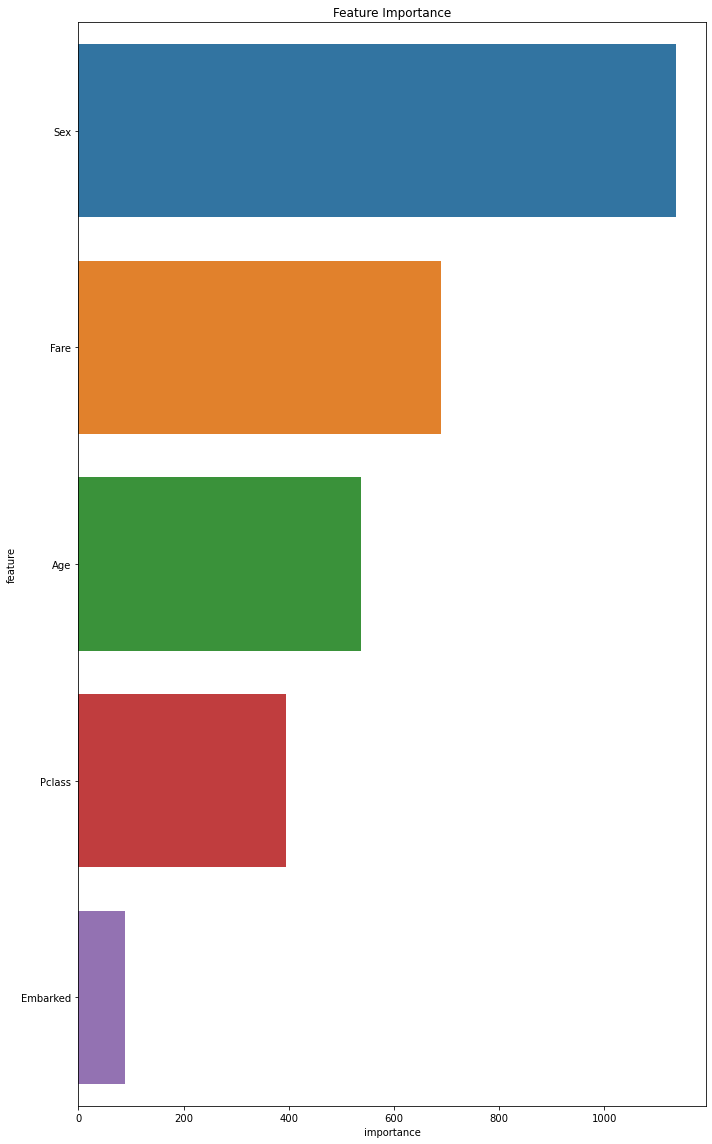

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from nyaggle.experiment import run_experiment

n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, random_state=42)

lgb_params = {
  'objective': 'binary',
  'boosting': 'gbdt',
  'metric': 'auc'
}

fit_params = {
    "early_stopping_rounds": 100,
    "verbose": 100
}

result = run_experiment(lgb_params,
                        train, target, test, fit_params=fit_params,
                        cv=skf, eval_func=roc_auc_score, sample_submission=gender_submission,
                        with_mlflow=True)

## See result with mlflow

see the result in the notebook and `localhost:5000`

In [ ]:
!mlflow ui

See http://localhost:5000/

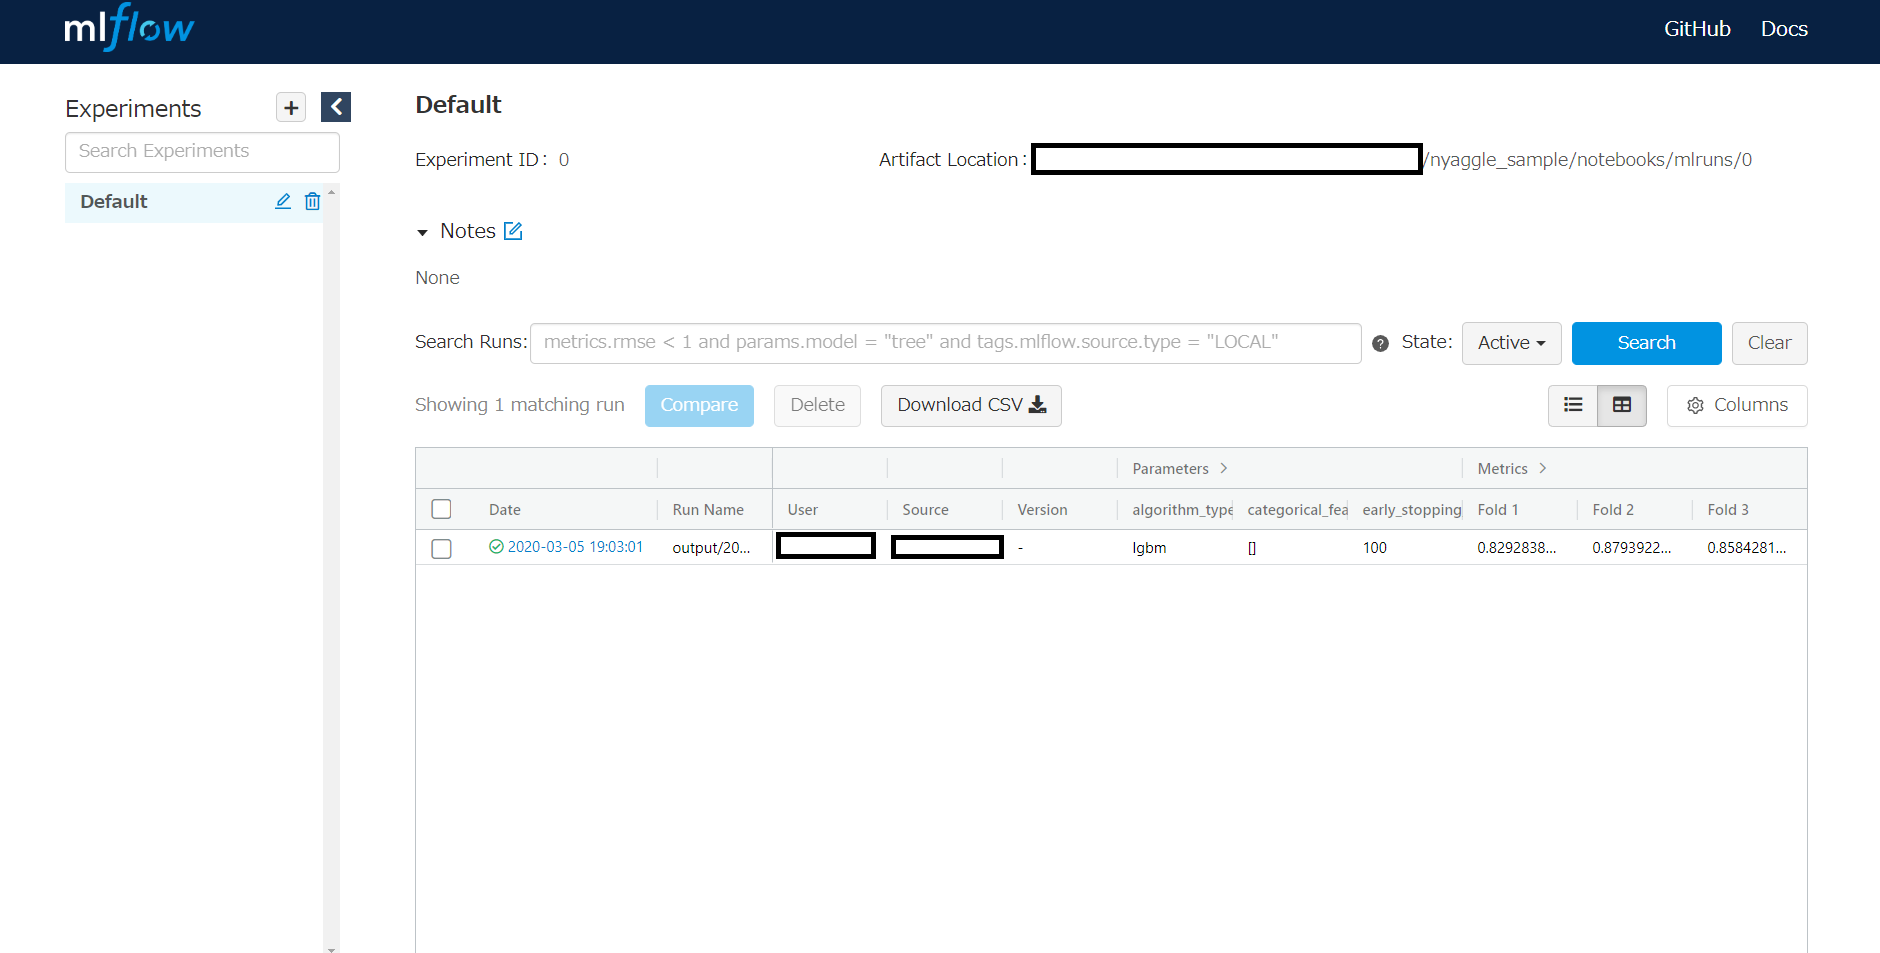


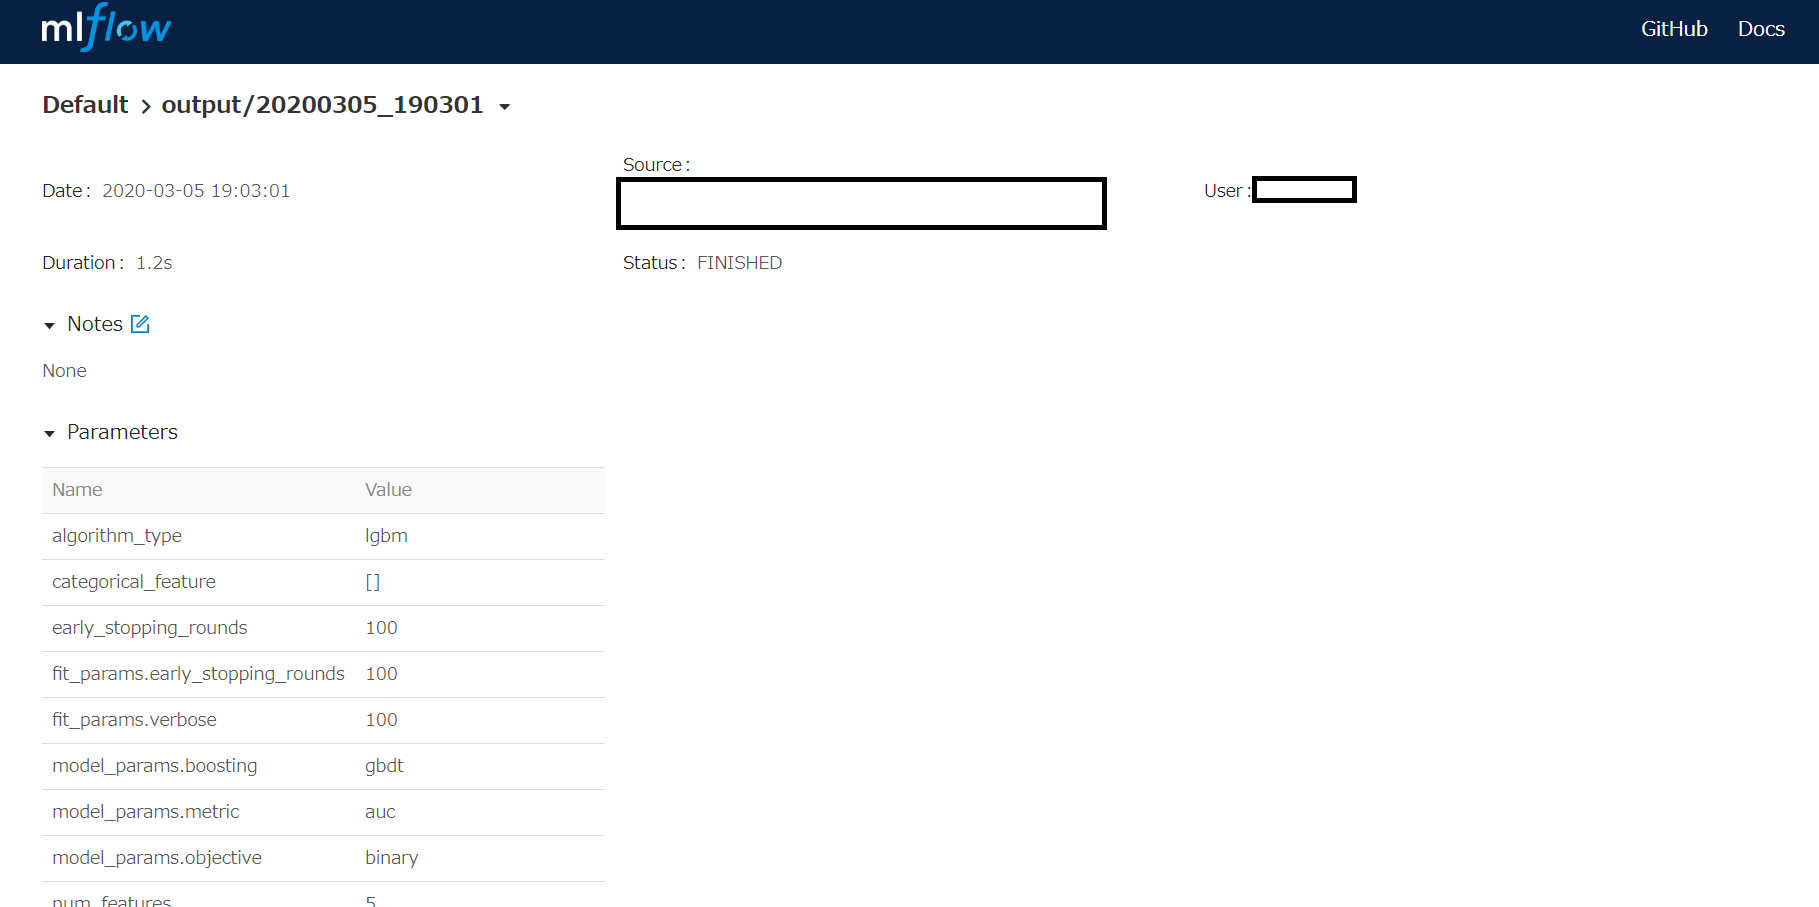


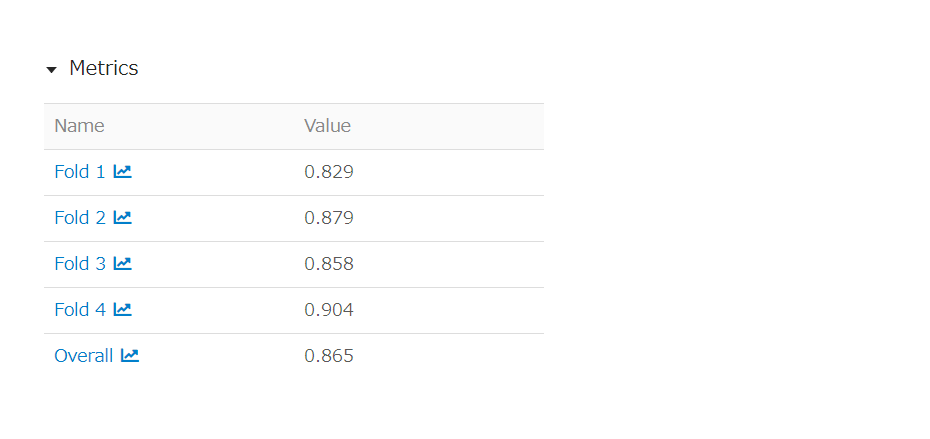


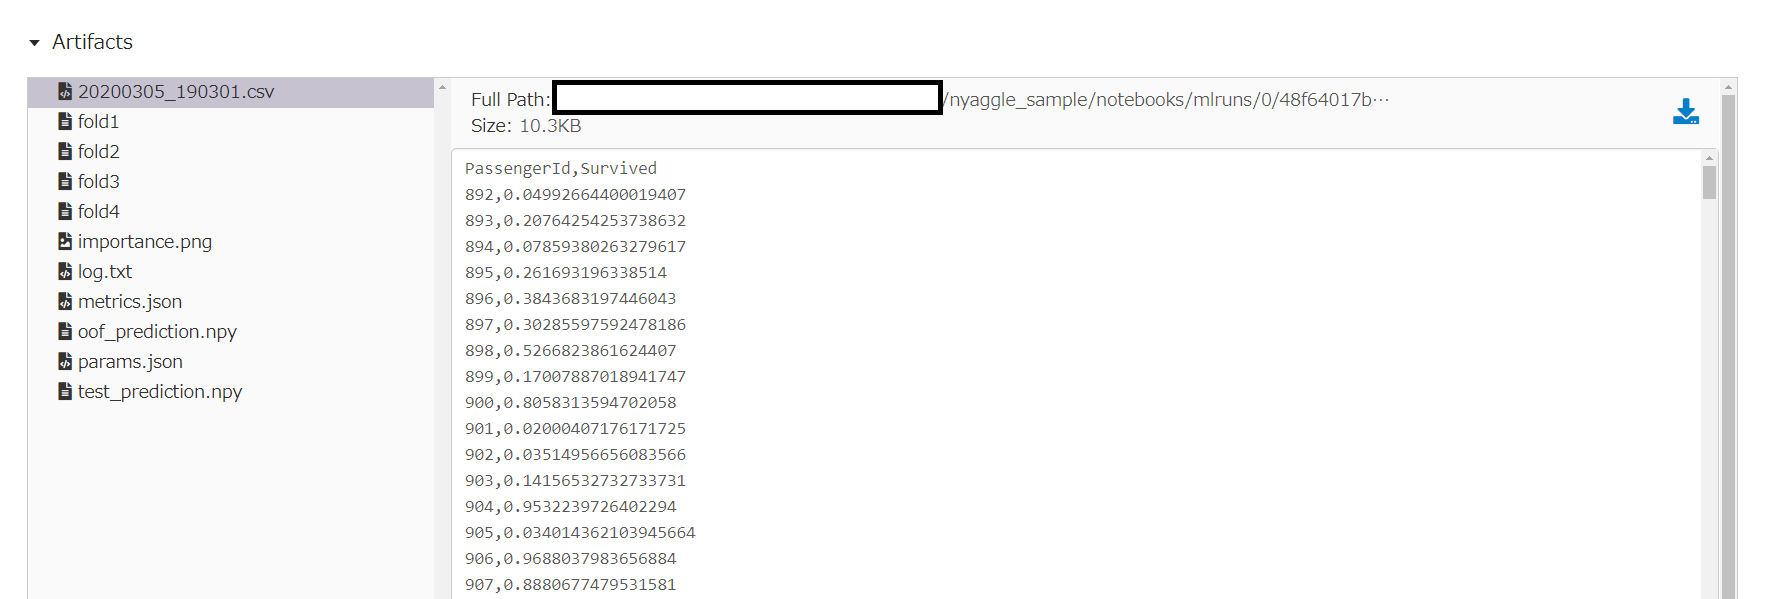